<a href="https://colab.research.google.com/github/Diptesh2006/ACM_ML-Pokemon-/blob/main/ACM_aiml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()


Saving archive (7).zip to archive (7).zip


In [2]:
import zipfile
import os

zip_path = "/content/archive (7).zip"
extract_path = "/content/pokemon_images"

# Unzip the archive
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully to:", extract_path)
print("Subfolders/files:", os.listdir(extract_path))

Unzipped successfully to: /content/pokemon_images
Subfolders/files: ['pokemon', 'pokemon_jpg']


In [3]:
import glob

# Look for PNG images recursively
image_paths = glob.glob("/content/pokemon_images/**/*.png", recursive=True)

print(f"Found {len(image_paths)} image files.")
print("Sample files:", image_paths[:10])

Found 819 image files.
Sample files: ['/content/pokemon_images/pokemon/pokemon/585-autumn.png', '/content/pokemon_images/pokemon/pokemon/40.png', '/content/pokemon_images/pokemon/pokemon/460.png', '/content/pokemon_images/pokemon/pokemon/15-mega.png', '/content/pokemon_images/pokemon/pokemon/350.png', '/content/pokemon_images/pokemon/pokemon/485.png', '/content/pokemon_images/pokemon/pokemon/256.png', '/content/pokemon_images/pokemon/pokemon/411.png', '/content/pokemon_images/pokemon/pokemon/443.png', '/content/pokemon_images/pokemon/pokemon/693.png']


In [4]:
import requests
import os

# Function to get color from PokeAPI using ID
def get_pokemon_color_by_id(poke_id):
    try:
        url = f"https://pokeapi.co/api/v2/pokemon-species/{poke_id}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            return data['color']['name']  # e.g. 'green'
        else:
            return "unknown"
    except:
        return "unknown"

# Build the label list
results = []

for path in image_paths:
    filename = os.path.basename(path)               # e.g., '12-mega.png'
    base_name = os.path.splitext(filename)[0]       # '12-mega'
    poke_id = base_name.split("-")[0]               # Get '12' from '12-mega'

    if poke_id.isdigit():
        color = get_pokemon_color_by_id(poke_id)
    else:
        color = "unknown"

    results.append({
        "Pokemon": filename,
        "Color": color
    })

print("✅ Done labeling! Here's a preview:")
for row in results[:10]:
    print(row)


✅ Done labeling! Here's a preview:
{'Pokemon': '585-autumn.png', 'Color': 'pink'}
{'Pokemon': '40.png', 'Color': 'pink'}
{'Pokemon': '460.png', 'Color': 'white'}
{'Pokemon': '15-mega.png', 'Color': 'yellow'}
{'Pokemon': '350.png', 'Color': 'pink'}
{'Pokemon': '485.png', 'Color': 'brown'}
{'Pokemon': '256.png', 'Color': 'red'}
{'Pokemon': '411.png', 'Color': 'gray'}
{'Pokemon': '443.png', 'Color': 'blue'}
{'Pokemon': '693.png', 'Color': 'blue'}


In [5]:
import pandas as pd

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Save to CSV
df.to_csv("pokemon_colors.csv", index=False)

print("✅ Saved as 'pokemon_colors.csv'")
df.head()  # Preview first few rows


✅ Saved as 'pokemon_colors.csv'


,Pokemon,Color
0,585-autumn.png,pink
1,40.png,pink
2,460.png,white
3,15-mega.png,yellow
4,350.png,pink


In [14]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Step 1: Reload the CSV (optional)
df = pd.read_csv("pokemon_colors.csv")

# Step 2: Add full image path column
df["filepath"] = df["Pokemon"].apply(lambda x: next((p for p in image_paths if x in p), None))

# Step 3: Drop rows where the path was not found
df = df[df["filepath"].notnull() & (df["Color"] != "unknown")]

# Step 4: Encode color labels (e.g., green → 0, red → 1, etc.)
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Color"])

# Step 5: Train/Validation split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#  AUGMENTED training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

#  VALIDATION data (no augmentation, just rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

#  Re-create generators
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="Color",
    target_size=(128, 128),
    class_mode="categorical",
    batch_size=32
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="Color",
    target_size=(128, 128),
    class_mode="categorical",
    batch_size=32
)


Found 650 validated image filenames belonging to 10 classes.
Found 163 validated image filenames belonging to 10 classes.


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Get the number of classes from the generator
num_classes = len(train_gen.class_indices)
print("Number of color classes:", num_classes)

# Build a simple CNN model
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


Number of color classes: 10


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,393,610 (28.20 MB)

 Trainable params: 7,393,610 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1419 - loss: 2.4777 - val_accuracy: 0.2025 - val_loss: 2.1254
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2721 - loss: 2.1042 - val_accuracy: 0.4172 - val_loss: 1.9369
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 977ms/step - accuracy: 0.3097 - loss: 1.9906 - val_accuracy: 0.2270 - val_loss: 2.1152
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2462 - loss: 2.1237 - val_accuracy: 0.3436 - val_loss: 1.8848
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 952ms/step - accuracy: 0.3386 - loss: 1.9333 - val_accuracy: 0.4110 - val_loss: 1.7256
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3997 - loss: 1.8339 - val_accuracy: 0.4847 - val_loss: 1.6730
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 940ms/step - accuracy: 0.4228 - loss: 1.7688 - val_accuracy: 0.4172 - val_loss: 1.6366
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3745 - loss: 1.8630 - val_accuracy: 0.4172 - 

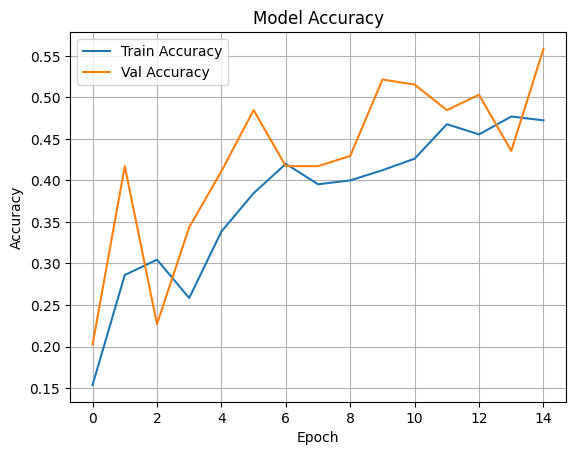

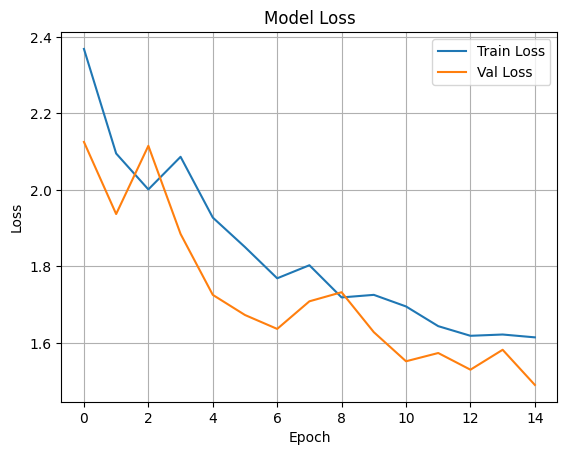

In [17]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 414ms/step


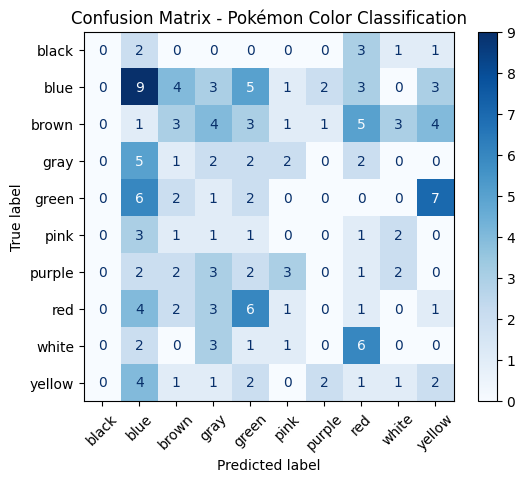

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Predict on validation data
val_gen.reset()  # reset the generator
pred_probs = model.predict(val_gen)
pred_classes = np.argmax(pred_probs, axis=1)

# Step 2: Get true labels
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())  # e.g., ['green', 'red', ...]

# Step 3: Compute confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Step 4: Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Pokémon Color Classification")
plt.show()


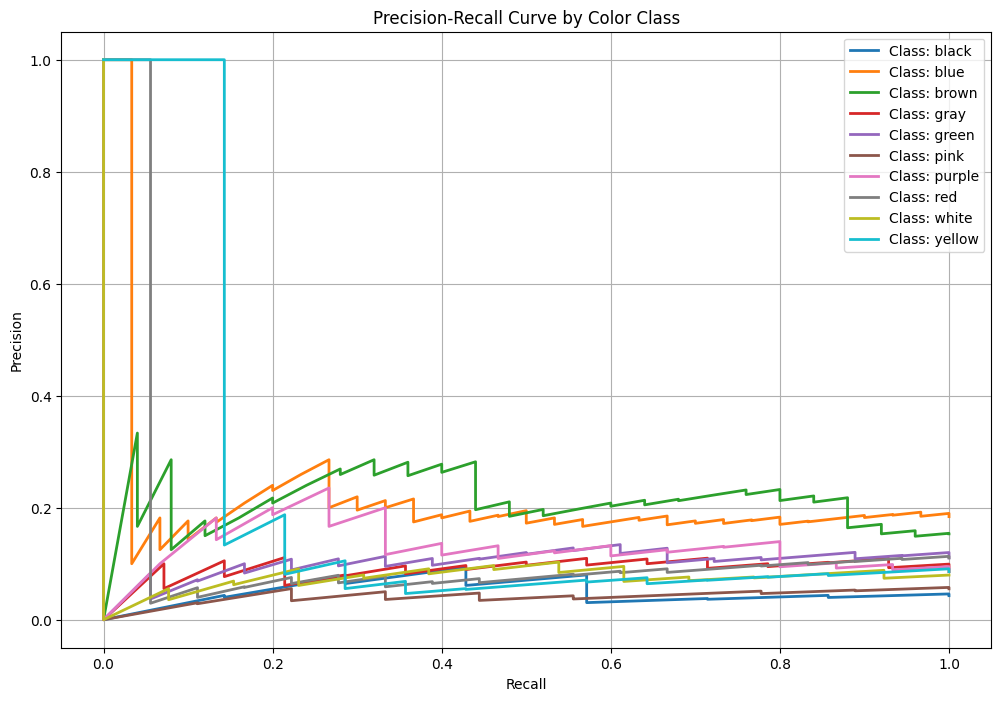

In [19]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize

# Step 1: Get true labels (binarized for multi-class PR curve)
y_true = label_binarize(val_gen.classes, classes=range(len(class_labels)))  # shape: (samples, num_classes)

# Step 2: Get prediction probabilities
y_score = pred_probs  # shape: (samples, num_classes)

# Step 3: Plot precision-recall curve for each class
plt.figure(figsize=(12, 8))
for i in range(len(class_labels)):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class: {class_labels[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve by Color Class")
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [21]:
from sklearn.metrics import classification_report

# Get true and predicted labels as integers
y_true = val_gen.classes
y_pred = pred_classes

# Generate the report
report = classification_report(y_true, y_pred, target_names=class_labels)

print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

       black       0.00      0.00      0.00         7
        blue       0.24      0.30      0.26        30
       brown       0.19      0.12      0.15        25
        gray       0.10      0.14      0.11        14
       green       0.08      0.11      0.10        18
        pink       0.00      0.00      0.00         9
      purple       0.00      0.00      0.00        15
         red       0.04      0.06      0.05        18
       white       0.00      0.00      0.00        13
      yellow       0.11      0.14      0.12        14

    accuracy                           0.12       163
   macro avg       0.08      0.09      0.08       163
weighted avg       0.10      0.12      0.11       163



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
val_filenames = val_gen.filenames
pred_labels = [class_labels[i] for i in pred_classes]

output_df = pd.DataFrame({
    "Pokemon": [os.path.basename(name) for name in val_filenames],
    "Predicted_Color": pred_labels
})

output_df.to_csv("model_predictions.csv", index=False)
print("Predictions saved to model_predictions.csv")


Predictions saved to model_predictions.csv
